# ATE estimations from real observational data
*This notebook examines the use of Bayesian Networks for estimating Average Treatment Effects (ATE) in Observational Studies within the Neyman-Rubin potential outcome framework from real data:* [N. Antonio et al. (2019)](https://www.sciencedirect.com/science/article/pii/S2352340918315191)

In [2]:
import pyAgrum as gum
import pyAgrum.lib.notebook as gnb
import pyAgrum.skbn as skbn
import pyAgrum.causal as csl
import pyAgrum.causal.notebook as cslnb

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

pd.set_option('future.no_silent_downcasting', True)

### Dataset
The data used in this notbook come from "Hotel booking demand datasets" by N. Antonio et al.
The data contains 31 variables describing the 104,641 observations. Each observation represents a hotel booking.

We aim to study the impact of assigning a different room to a customer on its likelihood to cancel the reservation. 
Here, some data preprocessing is needed to match our objectives.

In [3]:
df = pd.read_csv("../data/hotel_bookings.csv")
df.head()

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,deposit_type,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date
0,Resort Hotel,0,342,2015,July,27,1,0,0,2,...,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01
1,Resort Hotel,0,737,2015,July,27,1,0,0,2,...,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01
2,Resort Hotel,0,7,2015,July,27,1,0,1,1,...,No Deposit,NaN,NaN,0,Transient,75.0,0,0,Check-Out,2015-07-02
3,Resort Hotel,0,13,2015,July,27,1,0,1,1,...,No Deposit,304.0,NaN,0,Transient,75.0,0,0,Check-Out,2015-07-02
4,Resort Hotel,0,14,2015,July,27,1,0,2,2,...,No Deposit,240.0,NaN,0,Transient,98.0,0,1,Check-Out,2015-07-03


In [4]:
# Total stay in nights
df['total_stay'] = df['stays_in_week_nights'] + df['stays_in_weekend_nights']

# Total number of guests
df['guests'] = df['adults'] + df['children'] + df['babies']

# Creating the different_room_assigned feature
df['different_room_assigned'] = 0
slice_indices = df['reserved_room_type'] != df['assigned_room_type']
df.loc[slice_indices,'different_room_assigned'] = 1

# Deleting older features
df = df.drop(['stays_in_week_nights','stays_in_weekend_nights','adults','children',
                   'babies','reserved_room_type','assigned_room_type'],axis=1)

df.columns

Index(['hotel', 'is_canceled', 'lead_time', 'arrival_date_year',
       'arrival_date_month', 'arrival_date_week_number',
       'arrival_date_day_of_month', 'meal', 'country', 'market_segment',
       'distribution_channel', 'is_repeated_guest', 'previous_cancellations',
       'previous_bookings_not_canceled', 'booking_changes', 'deposit_type',
       'agent', 'company', 'days_in_waiting_list', 'customer_type', 'adr',
       'required_car_parking_spaces', 'total_of_special_requests',
       'reservation_status', 'reservation_status_date', 'total_stay', 'guests',
       'different_room_assigned'],
      dtype='object')

In [5]:
print(f"Number of Null entries: {df.isnull().sum()}")
df = df.drop(['agent','company'],axis=1)

# Replacing missing countries with most freqently occuring countries
df['country']= df['country'].fillna(df['country'].mode()[0])
df['guests']= df['guests'].fillna(df['guests'].mode()[0]).astype(int)

df = df.drop(['reservation_status','reservation_status_date','arrival_date_day_of_month'],axis=1)
df = df.drop(['arrival_date_year'],axis=1)
df = df.drop(['distribution_channel'], axis=1)

Number of Null entries: hotel                                  0
is_canceled                            0
lead_time                              0
arrival_date_year                      0
arrival_date_month                     0
arrival_date_week_number               0
arrival_date_day_of_month              0
meal                                   0
country                              488
market_segment                         0
distribution_channel                   0
is_repeated_guest                      0
previous_cancellations                 0
previous_bookings_not_canceled         0
booking_changes                        0
deposit_type                           0
agent                              16340
company                           112593
days_in_waiting_list                   0
customer_type                          0
adr                                    0
required_car_parking_spaces            0
total_of_special_requests              0
reservation_status               

In [6]:
# Replacing 1 by True and 0 by False for the experiment and outcome variables
df['different_room_assigned']= df['different_room_assigned'].replace(1,True)
df['different_room_assigned']= df['different_room_assigned'].replace(0,False)
df['is_canceled']= df['is_canceled'].replace(1,True)
df['is_canceled']= df['is_canceled'].replace(0,False)
df.dropna(inplace=True)
print(df.columns)
df.iloc[:, 5:20].head()

Index(['hotel', 'is_canceled', 'lead_time', 'arrival_date_month',
       'arrival_date_week_number', 'meal', 'country', 'market_segment',
       'is_repeated_guest', 'previous_cancellations',
       'previous_bookings_not_canceled', 'booking_changes', 'deposit_type',
       'days_in_waiting_list', 'customer_type', 'adr',
       'required_car_parking_spaces', 'total_of_special_requests',
       'total_stay', 'guests', 'different_room_assigned'],
      dtype='object')


,meal,country,market_segment,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,booking_changes,deposit_type,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,total_stay,guests
0,BB,PRT,Direct,0,0,0,3,No Deposit,0,Transient,0.0,0,0,0,2
1,BB,PRT,Direct,0,0,0,4,No Deposit,0,Transient,0.0,0,0,0,2
2,BB,GBR,Direct,0,0,0,0,No Deposit,0,Transient,75.0,0,0,1,1
3,BB,GBR,Corporate,0,0,0,0,No Deposit,0,Transient,75.0,0,0,1,1
4,BB,GBR,Online TA,0,0,0,0,No Deposit,0,Transient,98.0,0,1,2,2


In [7]:
df = df[df.deposit_type=="No Deposit"]
df.groupby(['deposit_type','is_canceled']).count()

hotel  lead_time  arrival_date_month  \
deposit_type is_canceled                                         
No Deposit   False        74947      74947               74947   
             True         29694      29694               29694   

                          arrival_date_week_number   meal  country  \
deposit_type is_canceled                                             
No Deposit   False                           74947  74947    74947   
             True                            29694  29694    29694   

                          market_segment  is_repeated_guest  \
deposit_type is_canceled                                      
No Deposit   False                 74947              74947   
             True                  29694              29694   

                          previous_cancellations  \
deposit_type is_canceled                           
No Deposit   False                         74947   
             True                          29694   

                          previous_bookings_not_canceled  booking_changes  \
deposit_type is_canceled                                                    
No Deposit   False                                 74947            74947   
             True                                  29694            29694   

                          days_in_waiting_list  customer_type    adr  \
deposit_type is_canceled                                               
No Deposit   False                       74947          74947  74947   
             True                        29694          29694  29694   

                          required_car_parking_spaces  \
deposit_type is_canceled                                
No Deposit   False                              74947   
             True                               29694   

                          total_of_special_requests  total_stay  guests  \
deposit_type is_canceled                                                  
No Deposit   False                            74947       74947   74947   
             True                             29694       29694   29694   

                          different_room_assigned  
deposit_type is_canceled                           
No Deposit   False                          74947  
             True                           29694

In [8]:
counts_sum=0
for i in range(1,1000):
        counts_i = 0
        rdf = df.sample(1000)
        counts_i = rdf[rdf["is_canceled"] == rdf["different_room_assigned"]].shape[0]
        counts_sum+= counts_i
print(f"Percentage of customers with different room assignment and cancelation : {counts_sum/1000000}")

Percentage of customers with different room assignment and cancelation : 0.588294


In [9]:
# Expected Count when there are no booking changes 
counts_sum=0
for i in range(1,1000):
        counts_i = 0
        rdf = df[df["booking_changes"]==0].sample(1000)
        counts_i = rdf[rdf["is_canceled"] == rdf["different_room_assigned"]].shape[0]
        counts_sum+= counts_i
counts_sum/1000000
print(f"Percentage of customers with different room assignment and cancelation when there are no booking changes : {counts_sum/1000000}")

Percentage of customers with different room assignment and cancelation when there are no booking changes : 0.572001


In [10]:
# Expected Count when there are booking changes = 66.4%
counts_sum=0
for i in range(1,1000):
        counts_i = 0
        rdf = df[df["booking_changes"]>0].sample(1000)
        counts_i = rdf[rdf["is_canceled"]== rdf["different_room_assigned"]].shape[0]
        counts_sum+= counts_i
counts_sum/1000000
print(f"Percentage of customers with different room assignment and cancelation when there are booking changes : {counts_sum/1000000}")

Percentage of customers with different room assignment and cancelation when there are booking changes : 0.665402


In [11]:
df = df.drop(columns=["customer_type", "arrival_date_month", "arrival_date_week_number", "adr", "previous_cancellations", "deposit_type"])

We observe that changes in a customer's booking may influence the probability of different room assignments and booking cancellations. We will now investigate whether a causal relationship exists between these factors.

### Bayesian Network Preparation
We use `skbn.BNDiscretizer` to discretize the continous variables found in the dataset. The structure of the network will also be provided, `gum.BNLearner` will be used for parameter learning.

In [12]:
for var in df.select_dtypes(include='number').columns:
    print(var, df[var].nunique())

lead_time 431
is_repeated_guest 2
previous_bookings_not_canceled 73
booking_changes 21
days_in_waiting_list 99
required_car_parking_spaces 5
total_of_special_requests 6
total_stay 45
guests 15


In [13]:
disc = skbn.BNDiscretizer(defaultNumberOfBins=5, defaultDiscretizationMethod="kmeans") #uniform causes the kernel to crash

disc.setDiscretizationParameters(variableName="lead_time", method="quantile")
disc.setDiscretizationParameters(variableName="is_repeated_guest", method="NoDiscretization")
disc.setDiscretizationParameters(variableName="previous_bookings_not_canceled", method="kmeans")
disc.setDiscretizationParameters(variableName="booking_changes", method="kmeans", paramDiscretizationMethod=5)
disc.setDiscretizationParameters(variableName="days_in_waiting_list", method="kmeans", paramDiscretizationMethod=5)
disc.setDiscretizationParameters(variableName="guests", method="kmeans", paramDiscretizationMethod=5)
disc.setDiscretizationParameters(variableName="total_stay", method="quantile")

template = disc.discretizedBN(df)

/home/thierry/.local/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:307: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(


In [14]:
template.addArc("market_segment", "lead_time")
template.addArc("lead_time", "is_canceled")
template.addArc("country", "lead_time")
template.addArc("different_room_assigned", "is_canceled")
template.addArc("country", "meal")
template.addArc("lead_time", "days_in_waiting_list")
template.addArc("days_in_waiting_list", "is_canceled")
template.addArc("days_in_waiting_list", "different_room_assigned")
template.addArc("previous_bookings_not_canceled", "is_canceled")
template.addArc("previous_bookings_not_canceled", "is_repeated_guest")
template.addArc("is_repeated_guest", "different_room_assigned")
template.addArc("is_repeated_guest", "is_canceled")
template.addArc("total_stay", "is_canceled")
template.addArc("guests", "is_canceled")
template.addArc("booking_changes", "different_room_assigned")
template.addArc("booking_changes", "is_canceled")
template.addArc("hotel", "different_room_assigned")
template.addArc("hotel", "is_canceled")
template.addArc("required_car_parking_spaces", "is_canceled")
template.addArc("total_of_special_requests", "booking_changes")
template.addArc("total_of_special_requests", "is_canceled")
template.addArc("country", "hotel")
template.addArc("country", "required_car_parking_spaces")
template.addArc("country", "total_of_special_requests")
template.addArc("market_segment", "hotel")
template.addArc("market_segment", "required_car_parking_spaces")
template.addArc("market_segment", "total_of_special_requests")

In [15]:
learner = gum.BNLearner(df, template)
learner.useNMLCorrection()
learner.useSmoothingPrior(1e-9)

bn = gum.BayesNet(template)
learner.fitParameters(bn)

(pyAgrum.BNLearner<double>@0x609ec7fc08e0) Filename       : /tmp/tmp8v165az6.csv
Size           : (104641,15)
Variables      : hotel[2], is_canceled[2], lead_time[5], meal[5], country[177], market_segment[8], is_repeated_guest[2], previous_bookings_not_canceled[5], booking_changes[5], days_in_waiting_list[5], required_car_parking_spaces[5], total_of_special_requests[6], total_stay[4], guests[5], different_room_assigned[2]
Induced types  : False
Missing values : False
Algorithm      : MIIC
Score          : BDeu  (Not used for constraint-based algorithms)
Correction     : NML  (Not used for score-based algorithms)
Prior          : Smoothing
Prior weight   : 0.000000

### Causal Model
A causal Baysian Network is then created using `csl.CausalModel`, a latent variable being the cause of multiple covariates is also added.

In [16]:
cslbn = csl.CausalModel(bn, [("U", ["total_of_special_requests", "required_car_parking_spaces", "total_stay", "guests"])])

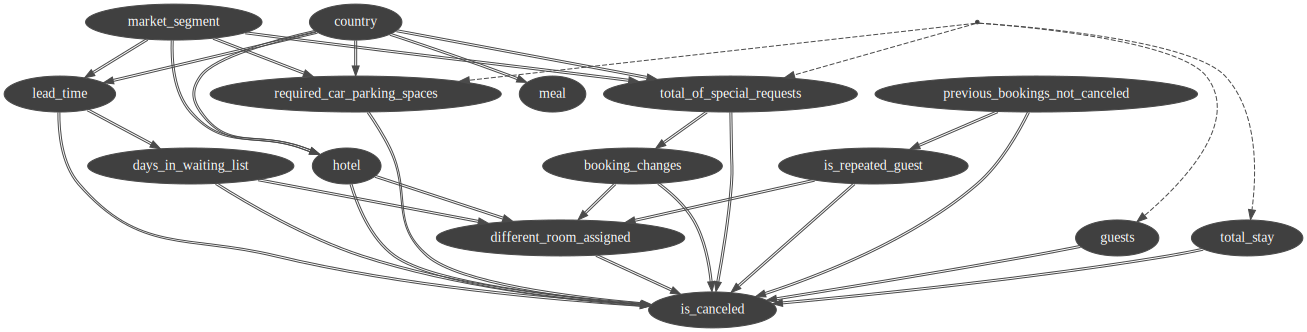

In [17]:
cslnb.showCausalModel(cslbn, size="50")

In [18]:
T = "different_room_assigned"
Y = "is_canceled"

In [19]:
cslnb.showCausalImpact(cslbn, doing=T, on=Y, values={T:1})

In [20]:
cslnb.showCausalImpact(cslbn, doing=T, on=Y, values={T:0})

In [21]:
gnb.showInformation(bn, size="50")

[pyAgrum] pyAgrum.lib.notebook.showInformation is deprecated since 0.20.2. Please use pyAgrum.lib.explain.showInfomation instead.


In [22]:
_, cpt0, _ = csl.causalImpact(cslbn, on=Y, doing=T, values={T:0})
_, cpt1, _ = csl.causalImpact(cslbn, on=Y, doing=T, values={T:1})
diff = cpt1 - cpt0
ate = diff.expectedValue(lambda d : diff.variable(0).numerical(d[diff.variable(0).name()]))
print(f"{ate = }")

ate = -0.2531058345752799


We observe a negative Average Treatment Effect (ATE), which is counterintuitive, as it suggests that assigning a different room reduces the likelihood of a reservation cancellation. To explore this further, we will examine the Conditional Average Treatment Effect (CATE) by conditioning on the covariates to provide additional insights.

# CATE estimations

In [23]:
def mutilateBN(bn : gum.BayesNet) -> gum.BayesNet:
    """
    Returns a copy of the Bayesian Network with all incoming arcs to the variable T removed.
    """
    res = gum.BayesNet(bn)
    for p_id in bn.parents(T):
        res.eraseArc(p_id, bn.idFromName(T))
    return res

def ATE(bn, X = {}, mutilate = True):
    """
    """

    ie = gum.LazyPropagation(mutilateBN(bn)) if mutilate else gum.LazyPropagation(bn)

    ie.setEvidence({T: 0} | X)
    ie.makeInference()
    p0 = ie.posterior(Y)

    ie.chgEvidence(T,1)
    ie.makeInference()
    p1 = ie.posterior(Y)

    diff = p1 - p0
    return diff.expectedValue(lambda d : diff.variable(0).numerical(d[diff.variable(0).name()]))

def cond_ATE_evo(bn, target):
    """
    """
    ate_list = list()
    for i in range(bn.variable(target).domainSize()):
        ate_list.append(ATE(bn, {target:i}))
    return ate_list

In [24]:
def get_xticks(var):
    var_type = var.varType()

    if var_type == 0:
        domain = var.domain()[1:-1].split(",")
        domain = [interval[1:-1].split(";") for interval in domain]
        domain = [f"[{float(interval[0]):.1f};{float(interval[1]):.1f}[" for interval in domain]
        domain[0] = "(" + domain[0][1:]
        domain[-1] = domain[-1][:-1] + ")"
    elif var_type == 2:
        domain = var.domain()[1:-1].split("|")
    elif var_type == 4:
        start_end = var.domain()[1:-1].split(",")
        domain = [str(i) for i in range(int(start_end[0]), int(start_end[1])+1)]
    else:
        domain = var.domain()
    return domain


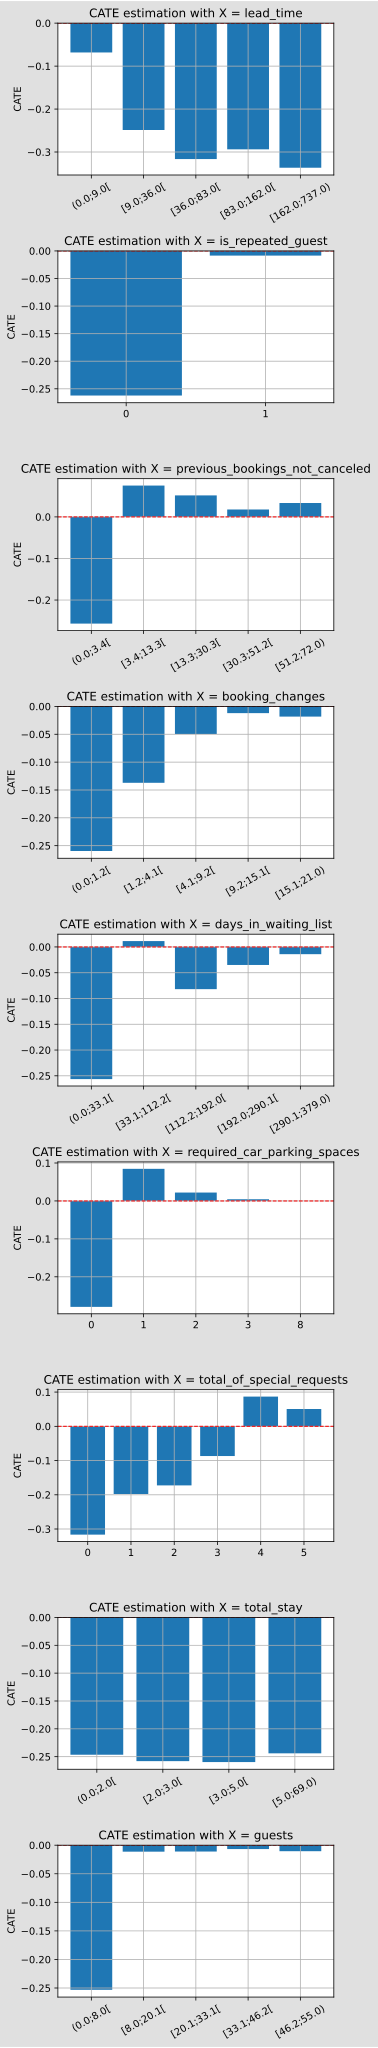

In [32]:
covar_list = df.select_dtypes(include='number').columns

plt.subplots(figsize=(5,4*len(covar_list)))

for i in range(len(covar_list)):

    plt.subplot(len(covar_list), 1, i+1)

    var = bn.variable(covar_list[i])
    xticks = get_xticks(var)

    plt.grid(True)

    plt.bar(range(len(xticks)), cond_ATE_evo(bn, covar_list[i]), alpha=1)
    #plt.plot(range(len(xticks)), cond_ATE_evo(bn, covar_list[i]))

    plt.xticks(ticks=range(len(xticks)), labels=xticks, 
               rotation=30 if var.varType() == 0 else 0)
    plt.ylabel("CATE")

    plt.axhline(y=0, color='r', linestyle='--', linewidth=1)
    plt.title(f"CATE estimation with X = {covar_list[i]}")

plt.subplots_adjust(wspace=0.5, hspace=0.5)
plt.show()

In [26]:
country_list = df["country"].value_counts()[:100].index
ATE_country_list = list()

for country in country_list:
    ATE_country_list.append(ATE(bn, {"country":country}))

ATE_country_df = pd.DataFrame(data={"ATE":ATE_country_list}, index=country_list)
ATE_country_df = ATE_country_df.sort_values(by="ATE")

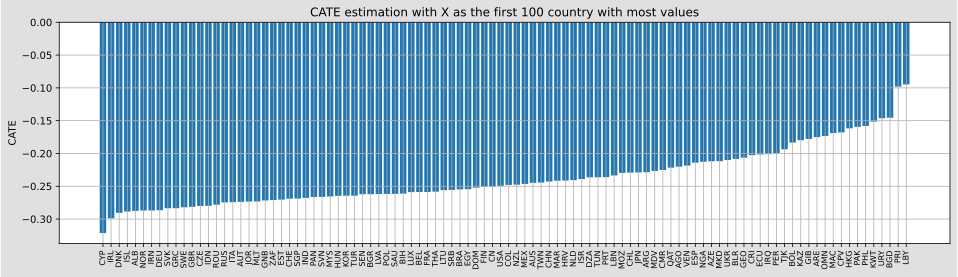

In [33]:
plt.figure(figsize=(16,4))
plt.bar(ATE_country_df.index, ATE_country_df["ATE"])
plt.xticks(rotation=90, size=8)
plt.ylabel("CATE")
plt.title(f"CATE estimation with X as the first 100 country with most values")
plt.grid(True)
plt.show()

In [28]:
market_seg_list = df["market_segment"].unique()
ATE_market_seg__list = list() 
for seg in market_seg_list:
    ATE_market_seg__list.append(ATE(bn, {"market_segment":seg}))

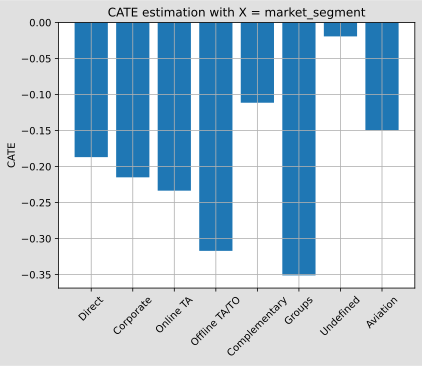

In [34]:
plt.bar(market_seg_list, ATE_market_seg__list)
plt.xticks(rotation=45)
plt.ylabel("CATE")
plt.title(f"CATE estimation with X = market_segment")
plt.grid(True)
plt.show()

In [30]:
hotel_list = df["hotel"].unique()
ATE_hotel_list = list() 
for hotel in hotel_list:
    ATE_hotel_list.append(ATE(bn, {"hotel":hotel}))

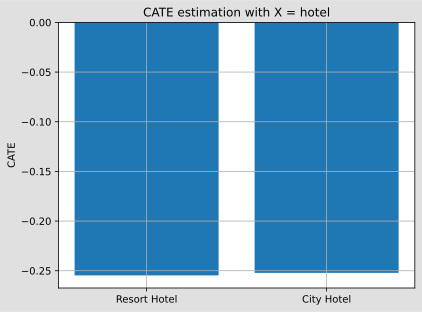

In [35]:
plt.bar(hotel_list, ATE_hotel_list)
plt.ylabel("CATE")
plt.title(f"CATE estimation with X = hotel")
plt.grid(True)
plt.show()